In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

import cv2
import pandas as pd
import ot
import ot.plot
import time
import numpy.linalg as la
import networkx as nx
import math
#from pointcloud_utils import vox_to_pointcloud
#import pointcloud_utils
from sklearn import manifold as man
# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

In [2]:
# Define the conversion functions
def vox_to_pointcloud(voxarray, grid, eps=0):
     
    xx, yy = np.squeeze(np.split(grid, 2))
    X = np.vstack((xx.ravel(), yy.ravel())).T
    nX = X.shape[0]
    nvi, nvj  = voxarray.shape
    if nX != nvi * nvj : raise ValueError("Number of grid points must equal number of voxels!")
    X = np.concatenate((X, voxarray.ravel().reshape(nvi * nvj, 1)), axis=1)
    return X[X[:, 2] > eps, :]

def pointcloud_to_vox(array, grid):
    xx, yy  = np.squeeze(np.split(grid, 2))
    points = array[:, 0:2]
    values = array[:, 2]
    interp = LinearNDInterpolator(points, values, fill_value=0.0)
    X = interp(xx, yy).T
    return X


In [3]:
def vox_to_pointcloud(voxarray,grid,eps=0):
    # Convert a voxel representation ('voxarray') to a (weighted) point cloud representation
    # Assume that the input grid is in "ij meshgrid" format i.e. the grid has two layers, xx and yy, each size (nx)-by-(ny)
    # The voxel array will be unrolled via "column-major" order ("Fortran/Matlab" ordering)
    # Note that initially the number of voxels must equal the number of grid points - but
    # zero voxels will be removed from the representation (i.e. no points with weight zero allowed)
    # if the optional parameter eps is passed, voxels with value less or equal to eps will be dropped
    # The returned array consists of (x,y,w) tuples i.e. X = [x1,y1,w1;x2,y2,w2;...;xP,yP,wP] where P
    # is the number of nonzero points
    xx,yy = np.squeeze(np.split(grid,2))
    X = np.vstack((xx.ravel(),yy.ravel())).T
    nX  = X.shape[0] # Number of points = number of rows
    nvi = voxarray.shape[0] # Number of voxel rows
    nvj = voxarray.shape[1] # Number of voxel cols
    if nX != nvi*nvj: raise ValueError("Number of grid points must equal number of voxels!")
    print(X.shape)
    print(voxarray.T.shape)
    X = np.concatenate((X,voxarray.T.reshape(nvi*nvj,1)),axis=1)
    return X[X[:,2]>eps,:]


def pointcloud_to_vox(array,grid):
    # Converts a pointcloud representation to a voxel representation
    # Assumes that the grid is in "ij meshgrid" format i.e. grid has two layers, xx and yy; each are size (nx+1)-by-(ny+1)
    # The grid points are assumed to define the corners of the voxels, so the
    # voxel rep will be a single nx-by-ny array with entries equal to the average pointcloud weights
    # V_ij = \mean_k W_k if (x_k,y_k) is in voxel ij
    xx,yy = np.squeeze(np.split(grid,2))

    points = array[:,0:2]
    values = array[:,2]
#   interp = NearestNDInterpolator(points,values)
    interp = LinearNDInterpolator(points,values,fill_value=0.0)
    X = interp(xx,yy).T
    #interp = RBFInterpolator(points,values,smoothing=0,kernel='linear')
    #X = np.reshape(interp(np.vstack((xx.ravel(),yy.ravel())).T),(xx.shape[0],xx.shape[1]))
    return X

grid shape (2, 224, 224)
(50176, 2)
(224, 224)


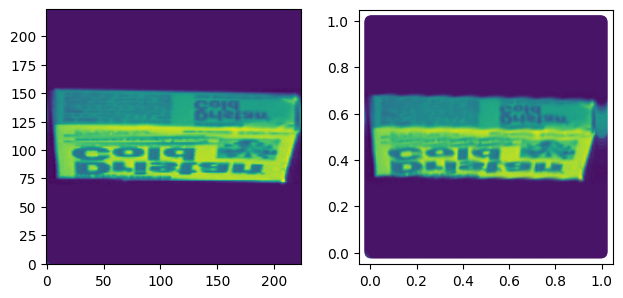

In [4]:
nxg = 224
nyg = 224
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud

def load_image_from_file(path):
    # Load the image
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (nxg, nyg))
    return image
    
path = "/Users/thienphuong/Desktop/DATA-4381-Capstone-Project/coil-100/obj1__0.png"
voxarray = load_image_from_file(path)
X = vox_to_pointcloud(voxarray, grid)


# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

In [5]:
def prepare_grid(nxg=224, nyg=224):
    x = np.linspace(0, 1, nxg)
    y = np.linspace(0, 1, nyg)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    grid = np.stack((xx, yy))
    return grid

def load_images_from_folder(folder):
    image_list = []
    labels_list = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        if os.path.isdir(path):
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    image_list.append(img)
                    labels_list.append(filename) 
    return image_list, labels_list

In [6]:
grouped_dir = "/Users/thienphuong/Desktop/DATA-4381-Capstone-Project/coil-100/processed/grouped"
images, labels = load_images_from_folder(grouped_dir)

In [7]:
# Randomly sample 1000 images
sample_size = 10
indices = np.random.choice(len(images), sample_size, replace=False)
sampled_images = [images[i] for i in indices]
sampled_labels = [labels[i] for i in indices]

In [8]:
# Convert sampled images to point clouds
point_clouds = []
grid = prepare_grid()
for image in sampled_images:
    resized_image = cv2.resize(image, (224, 224)) 
    point_cloud = vox_to_pointcloud(resized_image, grid)
    point_clouds.append(point_cloud)

(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)


In [9]:
def generate_rectangle(side0, side1, initial_point=[0,0], samples=100):
    # Generates a rectangle in point cloud format
    x = np.linspace(initial_point[0], initial_point[0]+side0, num=samples)
    y = np.linspace(initial_point[1], initial_point[1]+side1, num=samples)
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

def in_triangle(endpoint1,endpoint2,endpoint3,point):
    # Indicator function of a triangle
    # Returns 1 (True) if point is in the triangle, zero (False) else
    c1 = (endpoint2[0]-endpoint1[0])*(point[1]-endpoint1[1]) - (endpoint2[1]-endpoint1[1])*(point[0]-endpoint1[0])
    c2 = (endpoint3[0]-endpoint2[0])*(point[1]-endpoint2[1]) - (endpoint3[1]-endpoint2[1])*(point[0]-endpoint2[0])
    c3 = (endpoint1[0]-endpoint3[0])*(point[1]-endpoint3[1]) - (endpoint1[1]-endpoint3[1])*(point[0]-endpoint3[0])

    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        return True
    else:
        return False

def generate_triangle(endpoint1, endpoint2, endpoint3, samples=100):
    # Generates a triangle in point cloud format
    x = np.linspace(min(endpoint1[0],endpoint2[0],endpoint3[0]), max(endpoint1[0],endpoint2[0],endpoint3[0]), num=samples)
    y = np.linspace(min(endpoint1[1],endpoint2[1],endpoint3[1]), max(endpoint1[1],endpoint2[1],endpoint3[1]), num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_triangle(endpoint1,endpoint2,endpoint3,point):
            xy.append(point)
    return np.array(xy)

def in_circle(center, radius, point):
    if (point[1]-center[1])**2+(point[0]-center[0])**2<=radius**2:
        return True
    else:
        return False

def generate_circle(center, radius, samples=100):
    x = np.linspace(center[0]-radius, center[0]+radius, num=samples)
    y = np.linspace(center[1]-radius, center[1]+radius, num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_circle(center,radius,point):
            xy.append(point)
    return np.array(xy)

def generate_ellipse(center, axis_x, axis_y,samples = 100):
    circle = generate_circle([0,0],1,samples)
    ellipse = dilation(circle,[axis_x, axis_y])
    ellipse = translation(ellipse,center)
    return np.array(ellipse)

In [10]:
def uniform_Wass_squared(U, V,Itermax=100000):
    # Assumes that U and V are pointclouds i.e. U = [x1,y1,w1;...;xp,yp,wp] etc
    Upts = np.ascontiguousarray(U[:,0:2])
    Vpts = np.ascontiguousarray(V[:,0:2])
    Uwts = np.ascontiguousarray(U[:,2])
    Vwts = np.ascontiguousarray(V[:,2])
    Uwts = Uwts/np.sum(Uwts)
    Vwts = Vwts/np.sum(Vwts)
    M = ot.dist(Upts, Vpts)  # Compute euclidean distance on the pointcloud points
    W = ot.emd2(Uwts,Vwts, M,numItermax=Itermax)
    return W

def Wasserstein_Matrix(image_list,squared=True):
    """
    The function compute the (squared if squared=True) Wasserstein Distance Matrix between N images
    image_list: python list of pointcloud representations
    """
    N = len(image_list) #number of images
    distance = np.zeros((N,N)) #initialize the distance matrix

    #cost = ot.dist(supp, supp) #should be a MXM array
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])
            else:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])**.5
    distance += distance.T
    return distance

def Euclidean_Matrix(image_tensor,squared=True):
    """
    The function compute the (squared if squared=True) Euclidean Distance Matrix between N 2D images
    image_tensor: Should be a Mx2xN array, where M is the number of pixels.
    """
    N = image_tensor.shape[-1] #number of rows
    distance = np.zeros((N,N)) #initialize the distance matrix
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])**2
            else:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])
    distance += distance.T
    return distance

def Geodesic_Matrix(image_tensor,eps,squared=True):
    """
    Computes the Geodesic distance matrix for a set of N images
    image_tensor is Mx2xN
    """
    Euc_distance = Euclidean_Matrix(image_tensor,squared=False)
    Adj_matrix = np.copy(Euc_distance)
    Adj_matrix[Adj_matrix<eps] = 0
    Euc_distance[Euc_distance<eps] = np.Inf
    G = nx.from_numpy_array(Adj_matrix)
    geo_matrix = shortest_path(Euc_distance, directed=False, return_predecessors=False)
    if(squared==True):
        geo_matrix = np.square(geo_matrix)
    return geo_matrix,G

def MDS(distance_matrix, num_components=2, squared=False):
    """
    Computes non-metric (classical) Multidimensional Scaling (MDS)
    Input should be an NxN distance matrix
    The Boolean squared indicates if the distance matrix passed to the function has already
    been squared entrywise (True) or not (False)
    """
    N = distance_matrix.shape[0]
    H = np.eye(N)-1/N*np.ones((N,N))
    if squared==False:
        B = -.5*H@(distance_matrix**2)@H
    else:
        B = -.5*H@distance_matrix@H
    U,S,VT = la.svd(B)
    embedding = U[:,:num_components]@np.diag(S[:num_components]**.5)
    return embedding

In [11]:
def rotation(object, radian_degree):
    A = [[math.cos(radian_degree), -math.sin(radian_degree)],[math.sin(radian_degree), math.cos(radian_degree)]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)
def translation(object, translate_direction):
    object_array = np.array(object)
    direction_array = np.array(translate_direction)
    image = [x + direction_array for x in object_array]
    return np.array(image)

def dilation(object, parameter):
    A = [[parameter[0], 0],[0, parameter[1]]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)

# def diffeo(object, diff_fun):
#     object_array = np.array(object)
#     image = [diff_fun(x) for x in object_array]
#     return np.array(image)

def diffeo(object, a,b):
    object_array = np.array(object)
    image = np.array([1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(a*object_array[:,0]), 1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(b*object_array[:,1])]).T
#    image = np.array([np.exp(a*object_array[:,0]), np.reciprocal((1+b*object_array[:,1])**2)]).T
    print(image.shape)
    return np.array(image)

(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)
(50176, 2)
(224, 224)


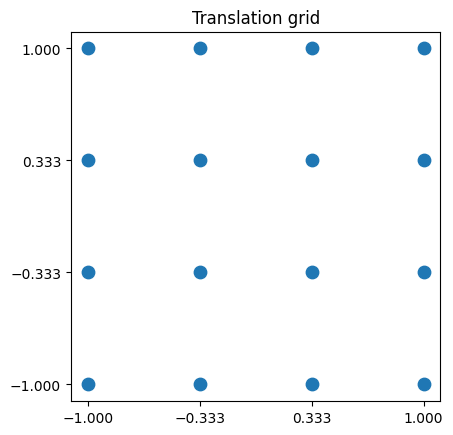

In [12]:
# Generate circle
num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]

# Plot the translation set
fig1,ax1 = plt.subplots()
ax1.scatter(translates[:,0],translates[:,1],s=80)
ax1.set_aspect('equal')
ax1.set_title('Translation grid')
ax1.set_xticks(x)
ax1.set_yticks(y)

#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/trans1_paramset.pdf',bbox_inches='tight')

trans_images = []
for image in sampled_images:
    resized_image = cv2.resize(image, (224, 224)) 
    point_cloud = vox_to_pointcloud(resized_image, grid)
    trans_images.append(point_cloud)

In [20]:
zeros_pointcloud = []
for point_cloud in point_clouds:
    # Filter to keep only points with a weight greater than -1
    filtered_cloud = point_cloud[point_cloud[:, 2] > -1]
    zeros_pointcloud.append(filtered_cloud)

In [22]:
zeros_pointcloud[0].shape

(50176, 3)

In [19]:
zeros_pointcloud = []
for i in range(len(point_clouds)):  # Use len() for lists
    zeros_pointcloud.append(vox_to_pointcloud(point_clouds[i], grid, -1))

ValueError: Number of grid points must equal number of voxels!

In [ ]:
 ## Circle translation test :: Compute Wasserstein square distance matrix usinng this
tic = time.perf_counter()
Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance_trans)

In [ ]:
WassEmbedding_trans = MDS(Wass_distance_trans, squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding_trans[:, 0]
scatter_y = WassEmbedding_trans[:, 1]
sc = ax1.scatter(scatter_x, scatter_y, c=y_subset, cmap='rainbow', s=50)
ax1.set_title('Wassmap Embedding')
plt.colorbar(sc, ax=ax1, orientation='vertical', pad=0.02)
plt.show()

In [ ]:
from sklearn.manifold import MDS, Isomap, TSNE, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
Wass_embedding_mds = mds.fit_transform(Wass_distance_trans)

In [25]:
sample_size = 100
indices = np.random.choice(len(images), sample_size, replace=False)
sampled_images = [images[i] for i in indices]
sampled_labels = [labels[i] for i in indices]

In [26]:
subset_train_reshaped = np.array(sampled_images).reshape(len(sampled_images), -1)
subset_train_labels = np.array(sampled_labels)

In [33]:
metrics = [True, False]  # Metric and non-metric MDS
eps_values = [1e-3, 1e-4, 1e-5]  
embeddings = {}

for metric_value in metrics:
    for eps in eps_values:
        embedding = MDS(n_components=2, metric=metric_value, eps=eps, random_state=0)
        train_transformed = embedding.fit_transform(subset_train_reshaped)
        embeddings[(metric_value, eps)] = train_transformed

TypeError: MDS() got an unexpected keyword argument 'n_components'